In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch.utils.data as data
import seaborn as sns
import matplotlib.pyplot as plt

from helper_functions import *
from data_functions import *
from models import *

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

## Przetwarzanie danych

In [30]:
data = pd.read_csv('train_data.csv')

def pipeline(data, target, train=True):
    data = output_to_labels(data, target)
    categories = data.select_dtypes(include="object").columns
    data = get_dummies(data, categories)
    data = remove_corr_features(data, "SalePrice", 0.8)
    return data

data = pipeline(data, 'SalePrice')
display(data.head())

,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesNearBy(Total),SalePrice,HallwayType_corridor,...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,2006,814,3,111.0,184.0,3.0,0.0,6.0,1,False,...,False,False,False,False,False,False,True,False,False,False
1,1985,587,8,80.0,76.0,2.0,2.0,12.0,0,True,...,True,False,False,False,False,True,False,False,False,False
2,1985,587,6,80.0,76.0,2.0,2.0,12.0,0,True,...,True,False,False,False,False,True,False,False,False,False
3,2006,2056,8,249.0,536.0,5.0,11.0,3.0,2,False,...,False,False,False,False,False,False,False,False,True,False
4,1992,644,2,142.0,79.0,4.0,8.0,9.0,0,False,...,False,False,False,False,False,False,False,True,False,False


## Wczytanie finałowego modelu

In [31]:
data = data_to_dataset(data, "SalePrice")

In [32]:
net = NetFinal(data.tensors[0].shape[1], 100, 3)
state_dict = torch.load("final_model.tar")
net.load_state_dict(state_dict)

<All keys matched successfully>

## Ewaluacja

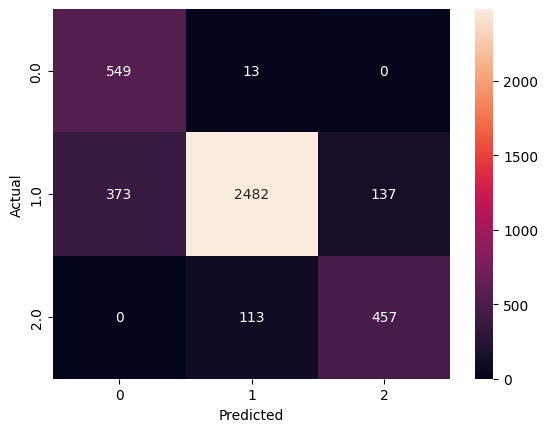

In [33]:
get_confusion_matrix_w(net, data)

In [34]:
get_balanced_accuracy(net, data)

0.8693893893041674

## Test

In [35]:
test = pd.read_csv('test_data.csv')
test['SalePrice'] = np.random.randint(0, 3, test.shape[0])

test = pipeline(test, 'SalePrice')
test = data_to_dataset(test, "SalePrice")

In [41]:
def get_results(net, test):
    results = []
    net.eval()
    for x, y in torch.utils.data.DataLoader(test, batch_size=1, shuffle=False):
        x = x.to(torch.device("cuda"))
        res = net(x).detach().cpu().numpy()
        res = np.argmax(res)
        results.append(res)
    return results

test_results = get_results(net, test)
test_results = pd.DataFrame(test_results, columns=["SalePrice"])
test_results.to_csv("test_results.csv", index=False)